In [1]:
import os
import sys
sys.path.append(os.getcwd())
from IPython.display import display
import torch
from torch import nn
import numpy as np
import pandas as pd 
import  altair as alt
import model
from model import Build_Transformer,Transformer 
import config
from config import get_weights_file_path,get_config,latest_weights_file_path
import train
from train import get_model,get_ds,greedy_decode,run_validation
import matplotlib.pyplot as plt
import warnings
import torchmetrics
warnings.filterwarnings('ignore')



In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
    # device='cpu'
print(f'using device {device}')


using device cuda


In [3]:
config = get_config()
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_piece_size(), tokenizer_tgt.get_piece_size()).to(device)

# Load the pretrained weights
model_filename = latest_weights_file_path(config)
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

80392
Max length of src sentance:79
Max length of tgt sentance:105


<All keys matched successfully>

In [5]:
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: print(msg), 0, None, num_examples=10)

--------------------------------------------------------------------------------
SOURCE:The burden of Damascus: "Behold, Damascus is taken away from being a city, and it will be a ruinous heap.
TARGET:Isihlabo esisingisele kwiDamasko. Yabona, iDamasko iya kususwa ekubeni ngumzi, ibe ngumwewe owileyo.
PREDICTED:Isihlabo esisingisele kwiDamasko. Yabona, iDamasko iya kususwa ekubeni ngumzi, ibe ngumwewe owileyo.
Blue score:0.0, char err rate:0.0, word err rate:0.0
--------------------------------------------------------------------------------
SOURCE:The distance from the rudder is also important.
TARGET:Umgama ukusuka kumphini wokusingisa ubalulekile.
PREDICTED:Umgama ukusuka kumphini wokusingisa ubalulekile.
Blue score:0.0, char err rate:0.0, word err rate:0.0
--------------------------------------------------------------------------------
SOURCE:Some of the sons of the priests prepared the confection of the spices.
TARGET:Koonyana bababingeleli bekukho abacola ubuqholo bobulawu.
PREDIC

In [6]:
def train_preds(model,validation_ds,tokenizer_src,tokenizer_tgt,max_len,device,print_msg,global_state,
                   writer,num_examples=2):
    model.eval()
    count=0

    source_texts=[]
    expected=[]
    predicted=[]

    console_width=80

    with torch.no_grad():
        for batch in validation_ds:
            count+=1
            encoder_input=batch['encoder_input'][0].to(device) #(B,Tx)
            encoder_mask=batch['encoder_mask'][0].to(device)   #(B,1,1,T)

           
           
            model_out=greedy_decode(model,encoder_input,encoder_mask,tokenizer_src,tokenizer_tgt,max_len,device)

            source_text=batch['src_text'][0]
            target_text=batch['tgt_text'][0]

            model_out_text=tokenizer_tgt.decode(model_out.detach().cpu().numpy().tolist())
            model_out_text = model_out_text.replace('[SOS]', '').replace('[EOS]', '').strip()

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            metric = torchmetrics.CharErrorRate()
            cer = metric(predicted, expected)
           

            # Compute the word error rate
            metric = torchmetrics.WordErrorRate()
            wer = metric(predicted, expected)
            

            # Compute the BLEU metric
            metric = torchmetrics.BLEUScore()
            bleu = metric(predicted, expected)

            print_msg('-'*console_width)
            print_msg(f'SOURCE:{source_text}')
            print_msg(f'TARGET:{target_text}')
            print_msg(f'PREDICTED:{model_out_text}')

            print_msg(f'Blue score:{bleu}, char err rate:{cer}, word err rate:{wer}')
 

            if count==num_examples:
                break

train_preds(model, train_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: print(msg), 0, None, num_examples=2)

--------------------------------------------------------------------------------
SOURCE:Hide your face from my sins, and blot out all of my iniquities.
TARGET:Sithelisa ubuso bakho ezonweni zam, Ubucime bonke ubugwenxa bam.
PREDICTED:Sisithelisa ubuso bakho ezonweni zam, Ucime zonke ubugwenxa bam.
Blue score:0.0, char err rate:0.078125, word err rate:0.3333333432674408
--------------------------------------------------------------------------------
SOURCE:Its upper edge is pierced with holes to receive the end of a strong wooden bar or lever, for heaving in cables.
TARGET:Umphezulu wayo isikwe yanemingxunya ukufumana umva wesixhathisi esinamandla, ukwenzela ukutsala ngamacingo.
PREDICTED:Umphezulu wayo isikwe yanemingxunya ukufumana umva wesixhathisi esinamandla, ukwenzela ukutsala ngamacingo.
Blue score:0.0, char err rate:0.02923976629972458, word err rate:0.15000000596046448


In [7]:
config = get_config()
train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, vocab_src.get_piece_size(), vocab_tgt.get_piece_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"19")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])



80392
Max length of src sentance:79
Max length of tgt sentance:105


<All keys matched successfully>

In [8]:
def load_next_batch():
    # Load a sample batch from the validation set
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)
    decoder_mask = batch["decoder_mask"].to(device)

    encoder_input_tokens = [vocab_src.id_to_piece(int(idx)) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [vocab_tgt.id_to_piece(int(idx)) for idx in decoder_input[0].cpu().numpy()]

    # check that the batch size is 1
    assert encoder_input.size(
        0) == 1, "Batch size must be 1 for validation"

    model_out = greedy_decode(
        model, encoder_input, encoder_mask, vocab_src, vocab_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens
    

In [41]:
# def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
#     return pd.DataFrame(
#         [
#             (
#                 r,
#                 c,
#                 float(m[r, c]),
#                 "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
#                 "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
#             )
#             for r in range(m.shape[0])
#             for c in range(m.shape[1])
#             if r < max_row and c < max_col
#         ],
#         columns=["row", "column", "value", "row_token", "col_token"],
#     )

# def get_attn_map(attn_type: str, layer: int, head: int):
#     if attn_type == "encoder":
#         attn = model.encoder.layers[layer].self_multihead_attention.attention_scores
#     elif attn_type == "decoder":
#         attn = model.decoder.layers[layer].self_multihead_attention.attention_scores
#     elif attn_type == "encoder-decoder":
#         attn = model.decoder.layers[layer].cross_multihead_attention.attention_scores
#     return attn[0, head].data

# def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
#     df = mtx2df(
#         get_attn_map(attn_type, layer, head),
#         max_sentence_len,
#         max_sentence_len,
#         row_tokens,
#         col_tokens,
#     )
#     return (
#         alt.Chart(data=df)
#         .mark_rect()
#         .encode(
#             x=alt.X("col_token", axis=alt.Axis(title="")),
#             y=alt.Y("row_token", axis=alt.Axis(title="")),
#             color="value",
#             tooltip=["row", "column", "value", "row_token", "col_token"],
#         )
#         #.title(f"Layer {layer} Head {head}")
#         .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
#         .interactive()
#     )

# def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], row_tokens: list, col_tokens, max_sentence_len: int):
#     charts = []
#     for layer in layers:
#         rowCharts = []
#         for head in heads:
#             rowCharts.append(attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len))
#         charts.append(alt.hconcat(*rowCharts))
#     return alt.vconcat(*charts)
    

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_attn_map(attn_type: str, layer: int, head: int):
    # Same as original
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_multihead_attention.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_multihead_attention.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_multihead_attention.attention_scores
    return attn[0, head].data.cpu().numpy()  # Convert to numpy array

def plot_attention(ax, matrix, row_tokens, col_tokens, max_len, layer, head):
    # Trim to max sentence length
    matrix = matrix[:max_len, :max_len]
    
    # Plot heatmap
    im = ax.imshow(matrix, aspect='auto')
    
    # Set labels
    ax.set_title(f"L{layer} H{head}", fontsize=10)
    ax.set_xticks(np.arange(len(col_tokens[:max_len])))
    ax.set_yticks(np.arange(len(row_tokens[:max_len])))
    
    # Format labels with token indices and text
    x_labels = [f"{i:03d} {t}" if i < len(col_tokens) else "<blank>" 
                for i, t in enumerate(col_tokens[:max_len])]
    y_labels = [f"{i:03d} {t}" if i < len(row_tokens) else "<blank>" 
                for i, t in enumerate(row_tokens[:max_len])]
    
    ax.set_xticklabels(x_labels, rotation=90, fontsize=6)
    ax.set_yticklabels(y_labels, fontsize=6)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.7,cmap='gray')

def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], 
                          row_tokens: list, col_tokens: list, max_sentence_len: int):
    n_layers = len(layers)
    n_heads = len(heads)
    
    # Create subplot grid
    fig, axs = plt.subplots(n_layers, n_heads, figsize=(4*n_heads, 4*n_layers))
    
    # Handle single layer/head case
    if n_layers == 1 and n_heads == 1:
        axs = np.array([[axs]])
    elif n_layers == 1 or n_heads == 1:
        axs = axs.reshape(n_layers, n_heads)
        
    # Plot each attention head
    for layer_idx, layer in enumerate(layers):
        for head_idx, head in enumerate(heads):
            ax = axs[layer_idx, head_idx]
            attn_matrix = get_attn_map(attn_type, layer, head)
            plot_attention(
                ax=ax,
                matrix=attn_matrix,
                row_tokens=row_tokens,
                col_tokens=col_tokens,
                max_len=max_sentence_len,
                layer=layer,
                head=head
            )
    
    plt.tight_layout()
    return fig

In [10]:
batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

Source: He said, "You shall take these seven ewe lambs from my hand, that it may be a witness to me, that I have dug this well."
Target: Wathi, La mathokazi ezimvu asixhenxe wowathabatha esandleni sam, abe bubungqina bam bokuba ndilimbile eli qula.


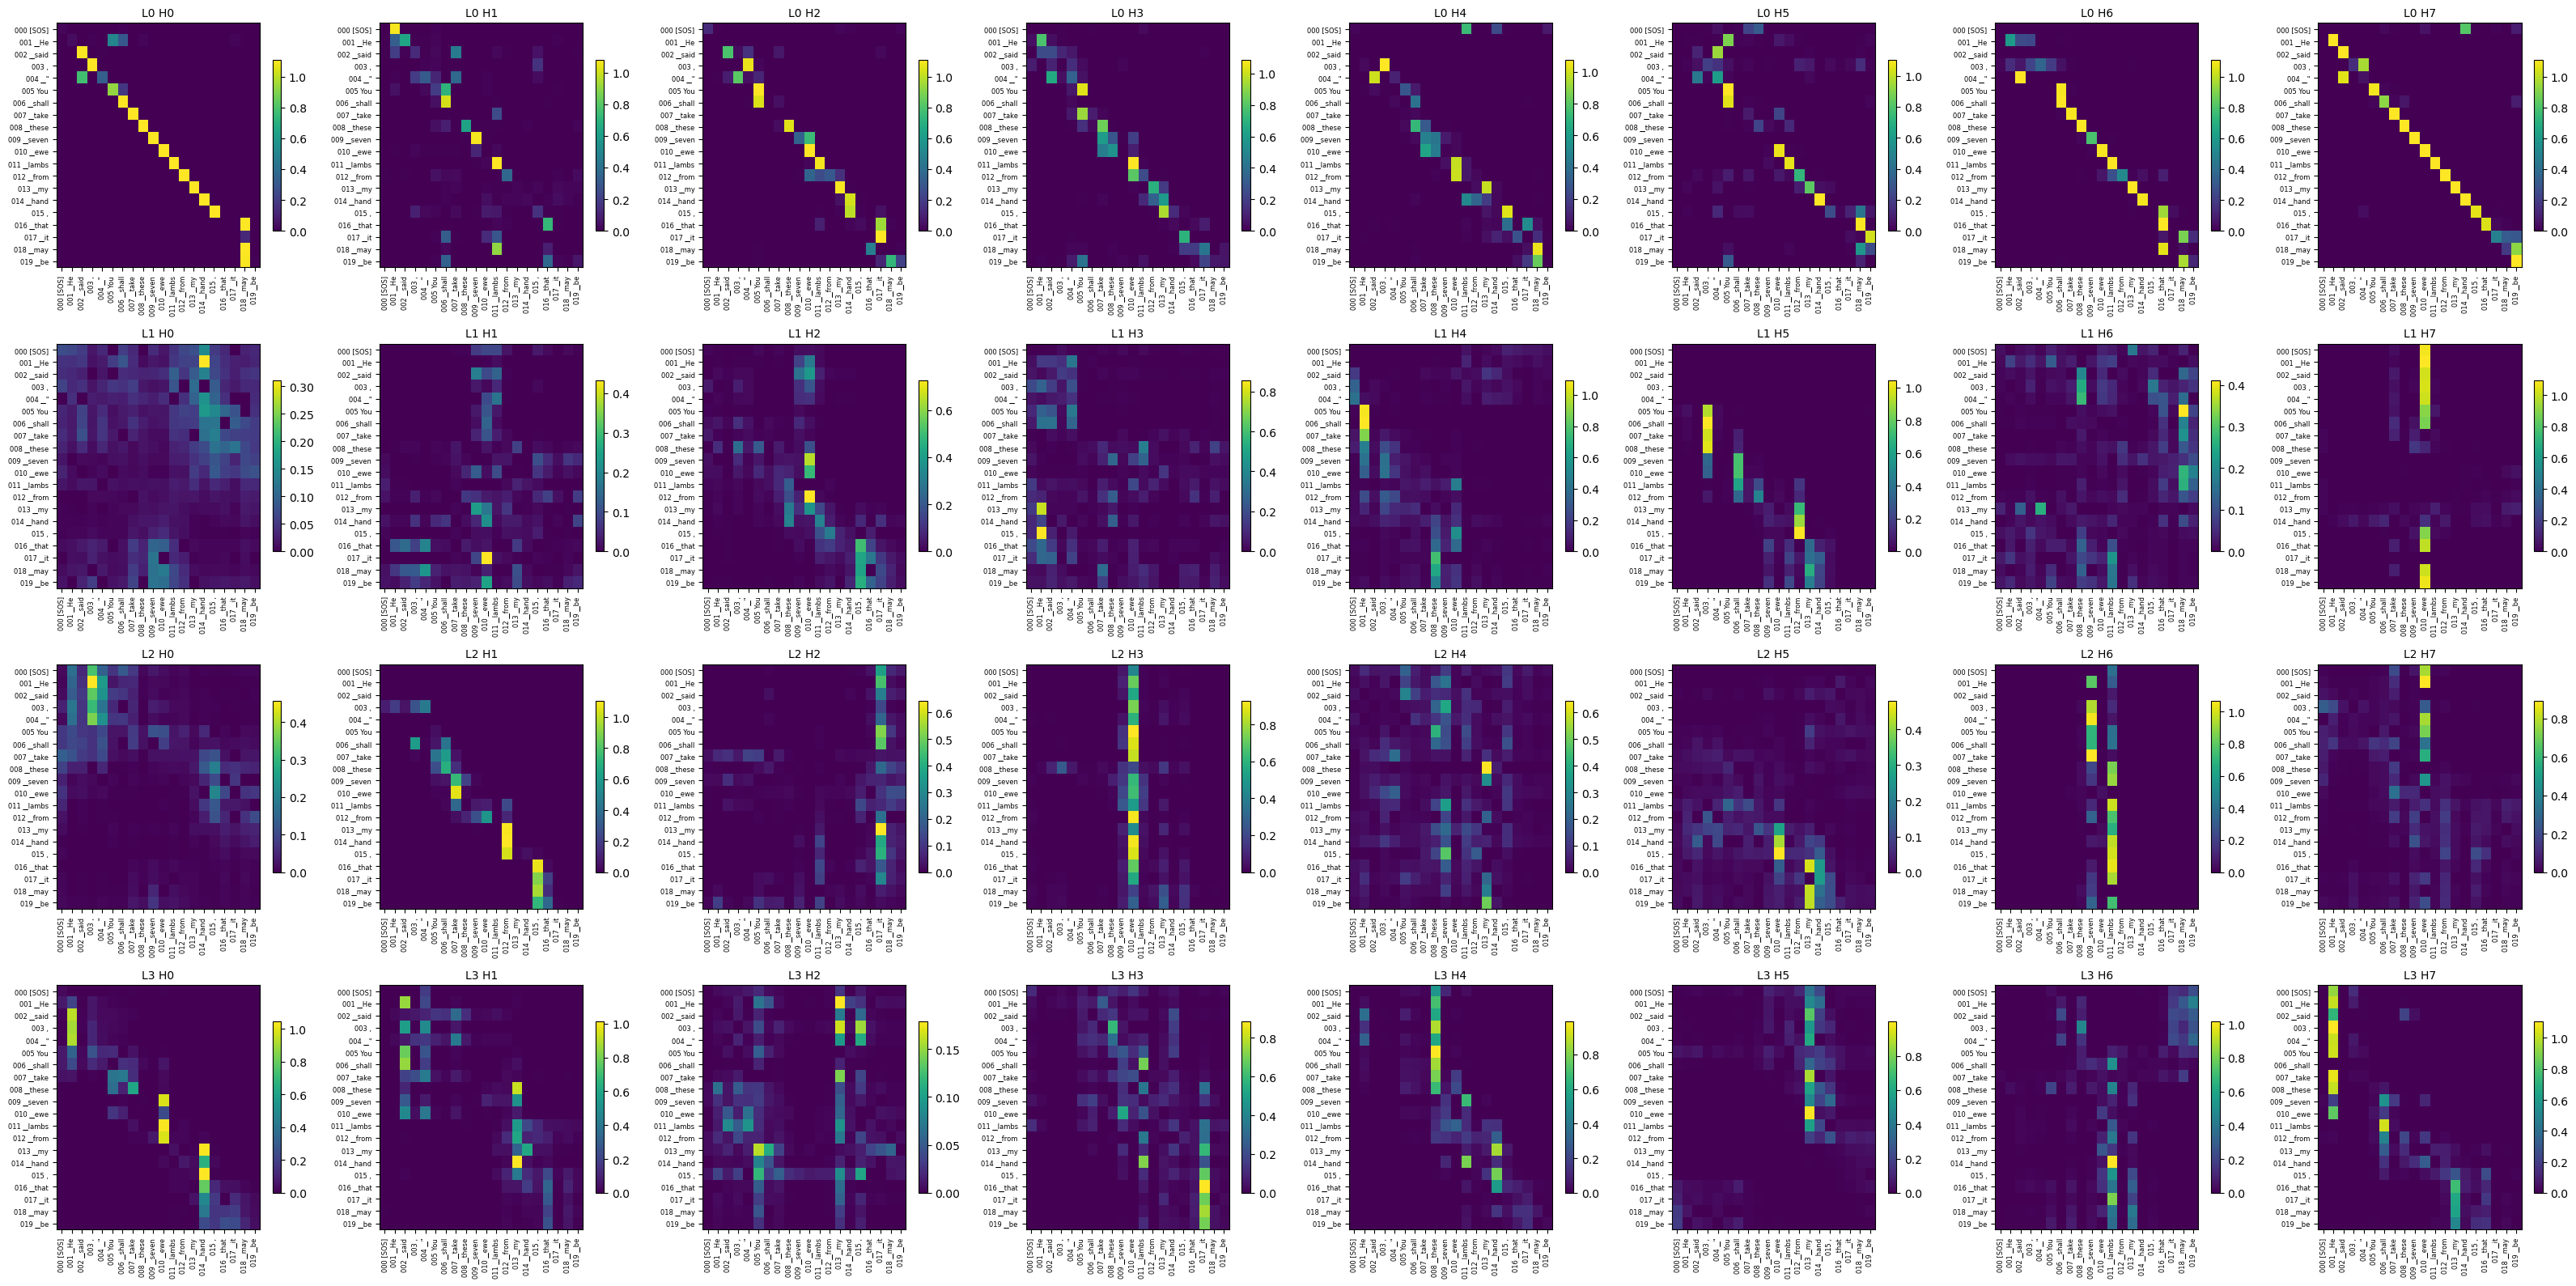

In [11]:
layers = [0,1,2,3]
heads = [0,1,2,3,4,5,6,7]

# Encoder Self-Attention
chart=get_all_attention_maps("encoder", layers, heads, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))
# plt.figure(figsize=(150,150))
chart.show()


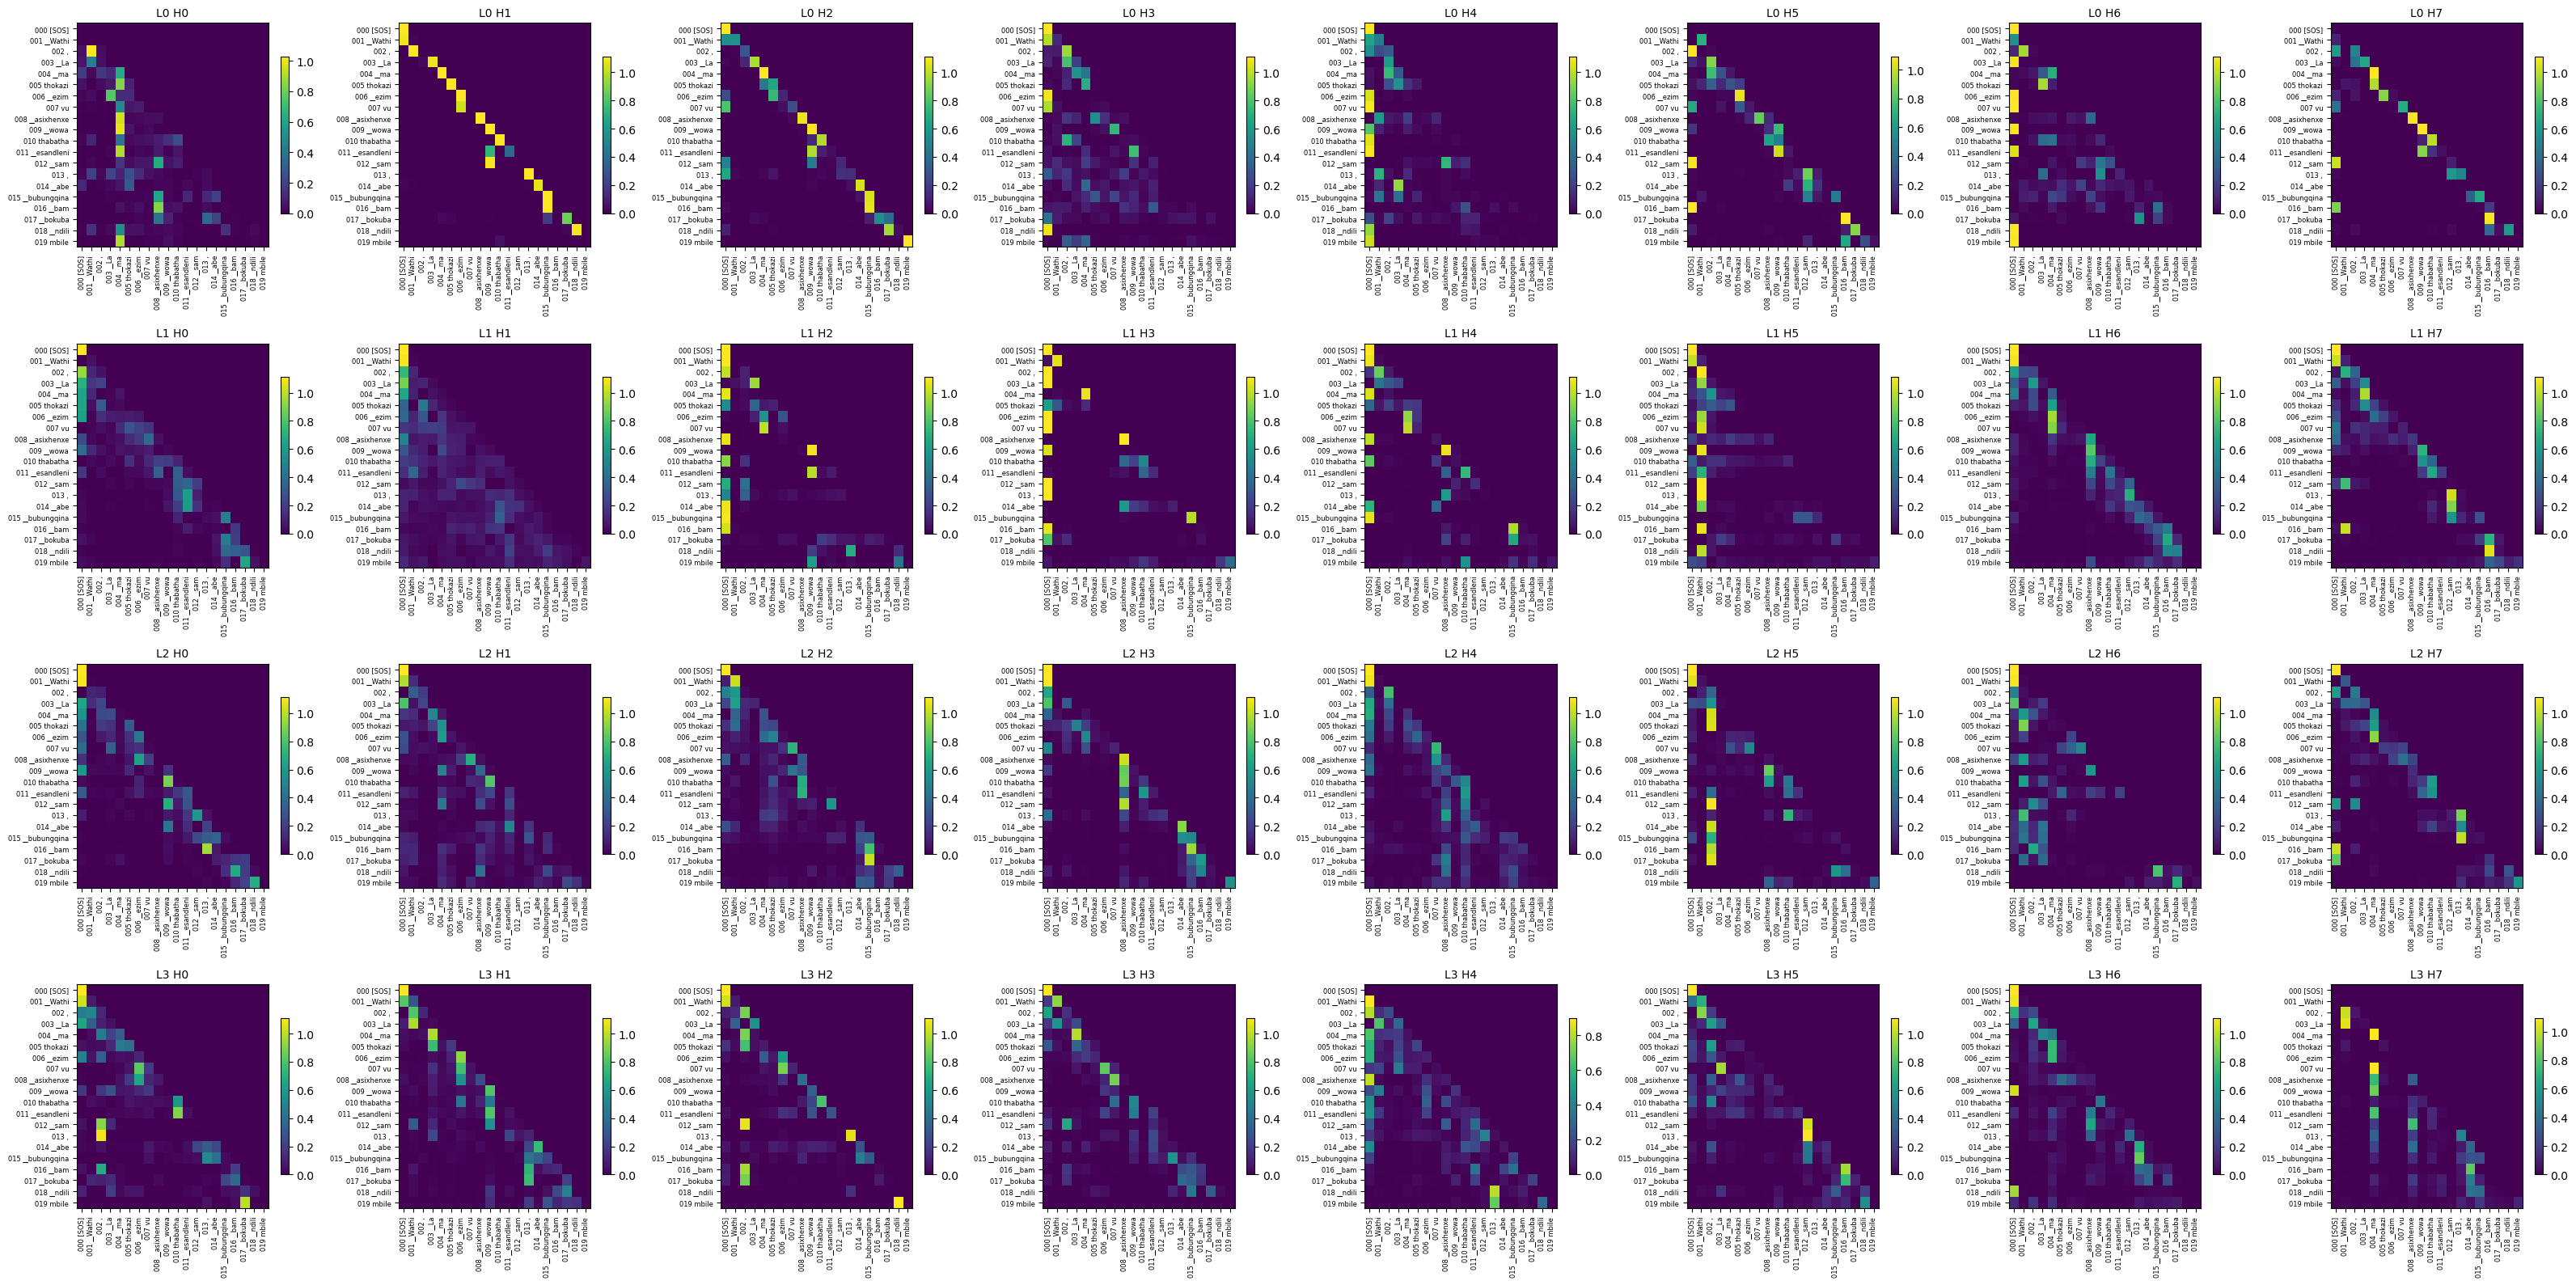

In [13]:
# Encoder Self-Attention
chart=get_all_attention_maps("decoder", layers, heads, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()

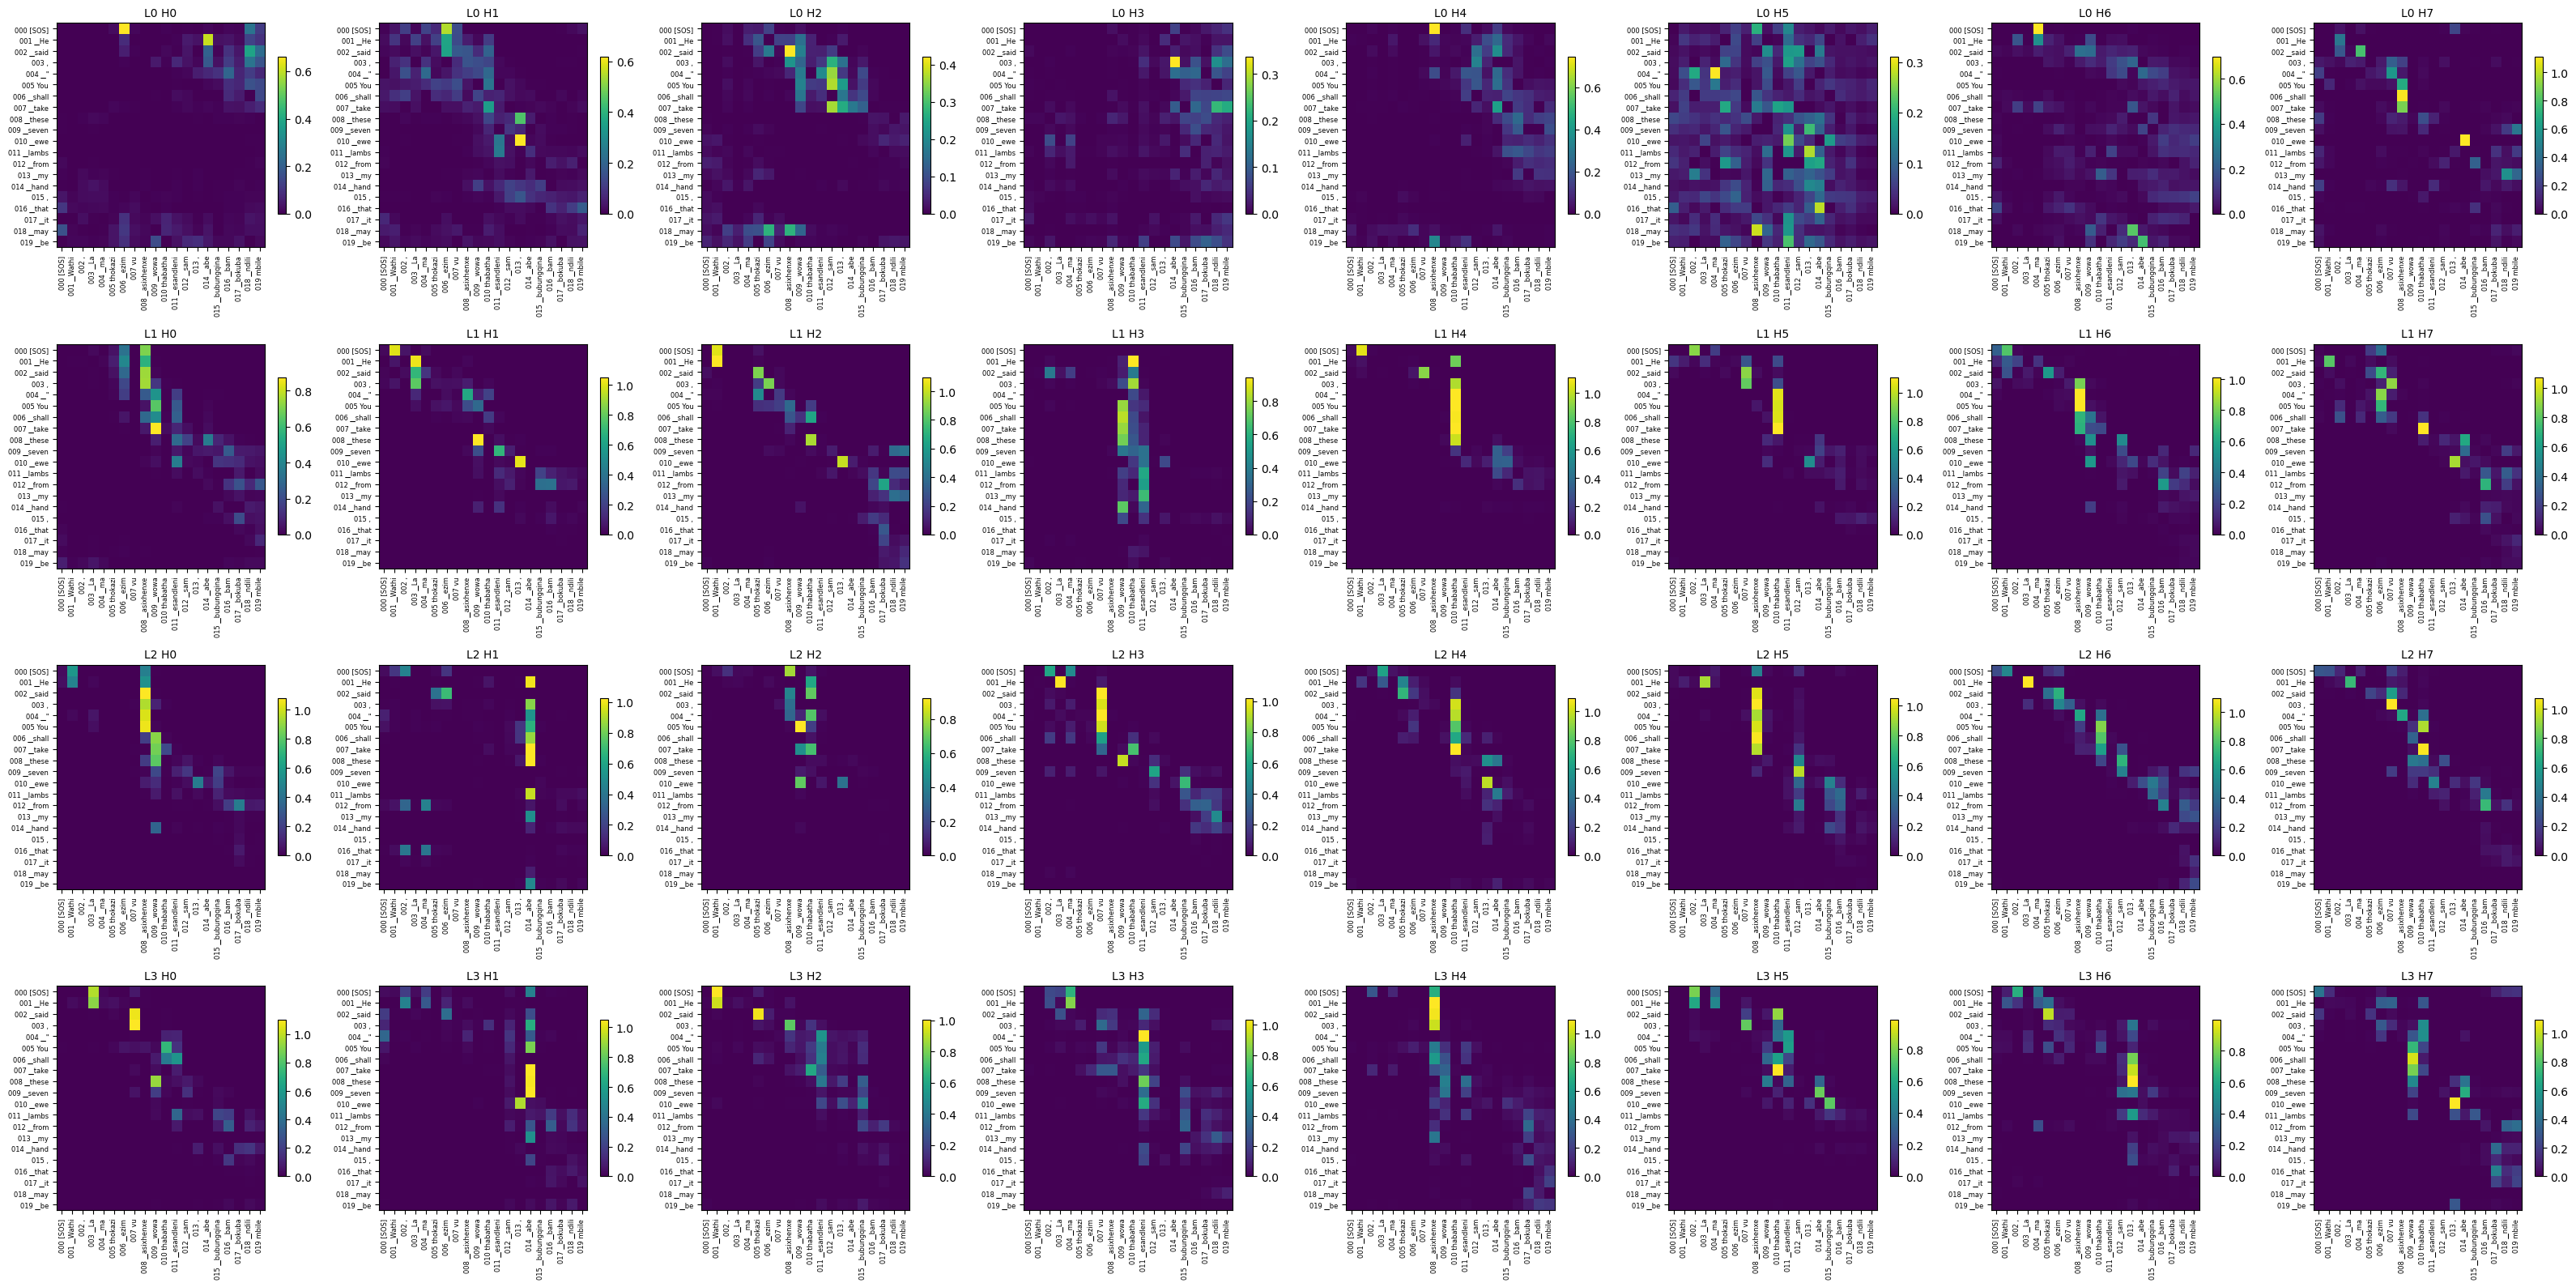

In [14]:
# Encoder Self-Attention
chart=get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()

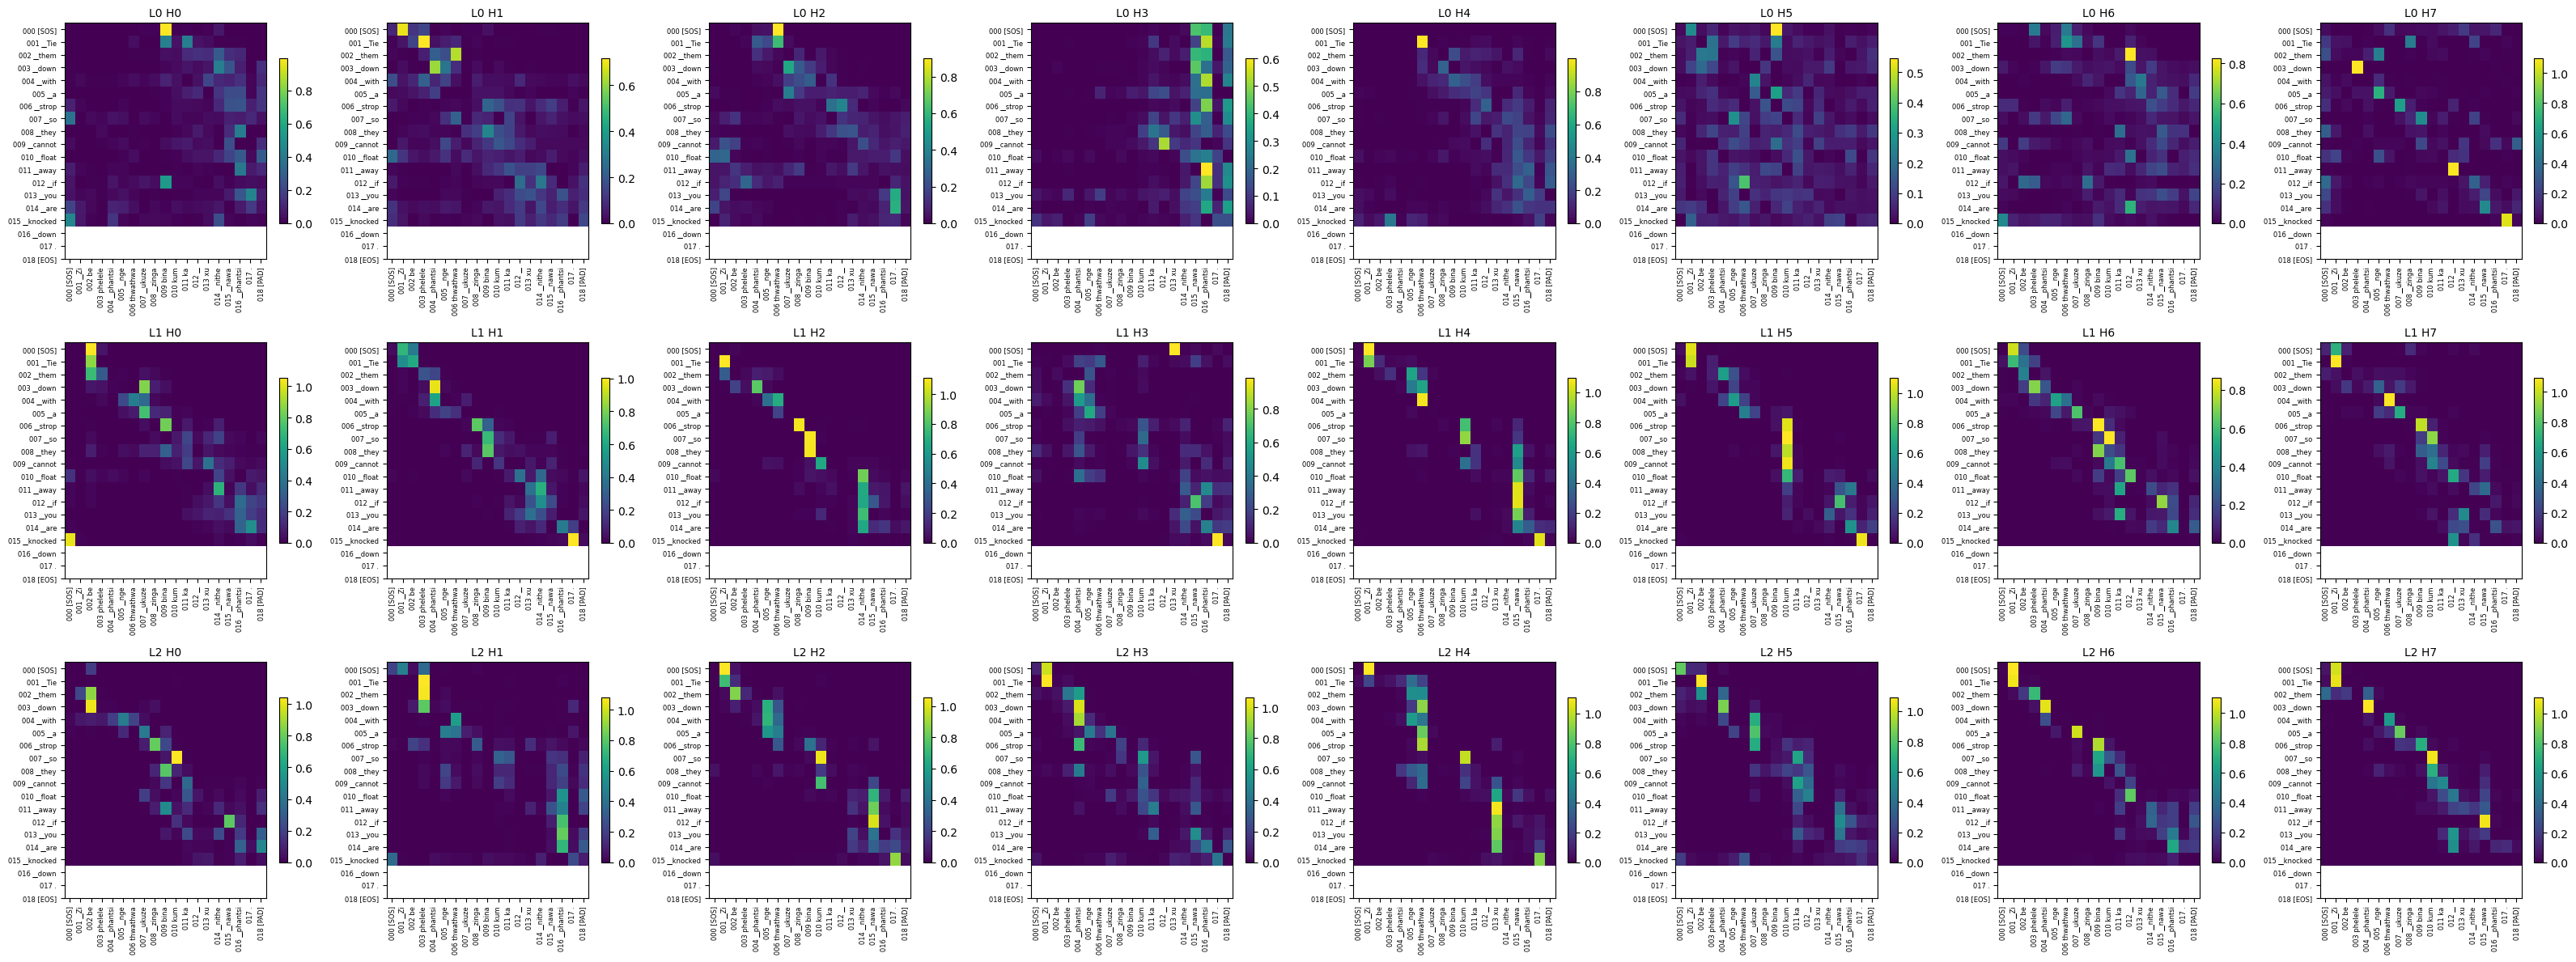

In [12]:
layers = [0,1,2]
heads = [0, 1, 2, 3,4,5,6,7]

chart=get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))
chart.show()